# Time Series Analysis and Forecasting

## Gathering Data and Imports

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn import metrics


In [ ]:
f_df = pd.read_csv("/kaggle/input/walmart-sales-forecast/stores.csv")
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


### **We will go with spark since the dataset is quite large and pandas is taking quite a time**

### Installing Spark and Creating Spark session

In [ ]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7be8de5250f30f7b917875a425cf0c5b32af97cf8d011fd2065ad23c1e565593
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 16:39:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading the Train.csv Dataset into a spark DataFrame

In [ ]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
df.limit(3).toPandas().style.hide(axis="index")

Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.500000,False
1,1,2010-02-12,46039.490000,True
1,1,2010-02-19,41595.550000,False


In [ ]:
mn_dt = df.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = df.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',df.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  421570
Min Date:  2010-02-05
Max Date:  2012-10-26


#### Loading Stores.csv into a dataframe

In [ ]:
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
stores.limit(3).toPandas().style.hide(axis="index")

Store,Type,Size
1,A,151315
2,A,202307
3,B,37392


In [ ]:
print('Total Rows: ', stores.count())
print('Total Stores: ', stores.select('Store').distinct().count())
stores.select('Type').distinct().show()

Total Rows:  45
Total Stores:  45
+----+
|Type|
+----+
|   B|
|   C|
|   A|
+----+



#### Loading features.csv into a dataframe

In [ ]:
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
features.limit(3).toPandas().style.hide(axis="index")

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,42.310000,2.572000,NA,NA,NA,NA,NA,211.0963582,8.106,False
1,2010-02-12,38.510000,2.548000,NA,NA,NA,NA,NA,211.2421698,8.106,True
1,2010-02-19,39.930000,2.514000,NA,NA,NA,NA,NA,211.2891429,8.106,False


In [ ]:
mn_dt = features.select('Date').agg(f.min('Date')).collect()[0][0]   # Extract min date
mx_dt = features.select('Date').agg(f.max('Date')).collect()[0][0]   # Extract max date
print('Total Rows: ',features.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  8190
Min Date:  2010-02-05
Max Date:  2013-07-26


#### **Joining entire dataset to make features**

In [ ]:
# Converting 'NA' strings in MarkDown columns to null values

for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))

In [ ]:
# Joining DataFrame df with DataFrame stores on the 'Store' column using inner join

pdf = df.join(stores, on='Store', how='inner').\
      join(features.drop('IsHoliday'), on=['Date','Store'], how='left').\
      toPandas()

# Converting the 'Date' column to datetime format
pdf['Date'] = pd.to_datetime(pdf['Date'])

# Setting the 'Date' column as the index of the DataFrame
pdf.set_index('Date', inplace=True)

# Converting 'CPI' column to numeric type with downcast to float
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")

# Converting 'Unemployment' column to numeric type with downcast to float
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")

# Displaying the first few rows of the DataFrame
pdf.head()


,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [ ]:
pdf.dtypes

Store             int32
Dept              int32
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int32
Temperature     float64
Fuel_Price      float64
MarkDown1       float32
MarkDown2       float32
MarkDown3       float32
MarkDown4       float32
MarkDown5       float32
CPI             float32
Unemployment    float32
dtype: object

## Visualizations

#### Stores Data

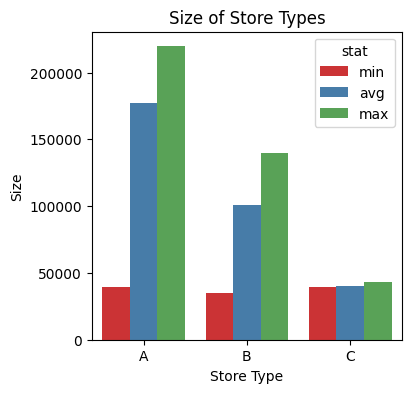

In [ ]:
# Grouping the stores DataFrame by 'Type' and calculating statistics on the 'Size' column

# Aggregating minimum, average (rounded to 2 decimal places), and maximum values of store size for each store type
stdf = stores.groupBy('Type').agg(
    f.min('Size').alias('min'),
    f.round(f.avg('Size'),2).alias('avg'),
    f.max('Size').alias('max')).orderBy('Type').toPandas()

# Melting the DataFrame stdf to reshape it for visualization
# Reshaping the DataFrame to have 'Type' as id variable and 'min', 'avg', 'max' as variable columns
m_df = pd.melt(stdf, id_vars="Type", var_name="stat", value_name="Size")

# Creating a bar plot to visualize the statistics of store size by store type
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(x='Type', y='Size', hue='stat', data=m_df, ax=ax, palette='Set1').set_title('Size of Store Types')
plt.xlabel('Store Type')
plt.show()

#### Observations
- Type 'A' are the biggest store types(most probably on the basis of their capacity) with highest 'max' and 'average'  
- Type 'C' are the smallest stores with lowest 'max' and 'average'    
- Type 'B' average store size is in the middle
- Similar info about the 'Type' column is given in introduction to this dataset
- But the Minimun store size is close for all the store types  

#### Sales Data

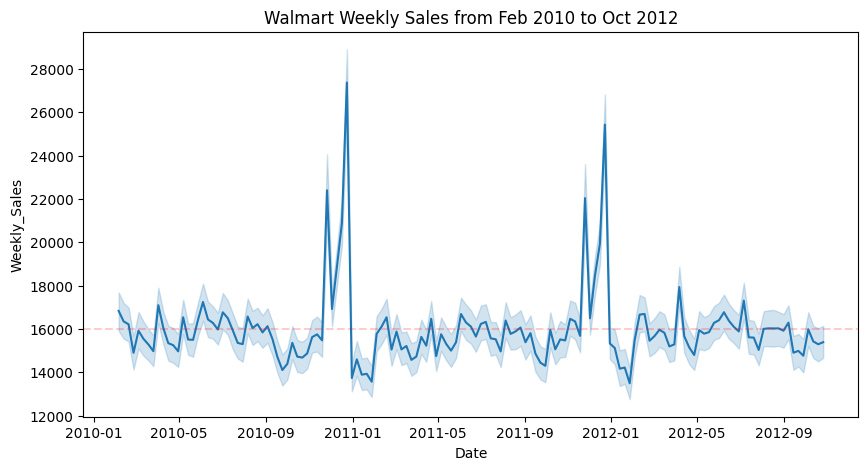

In [ ]:
plt.figure(figsize=(10,5))

# Plotting a line plot of 'Weekly_Sales' against 'Date' from the pdf DataFrame
sns.lineplot(data=pdf,
             x='Date',
             y='Weekly_Sales').set_title('Walmart Weekly Sales from Feb 2010 to Oct 2012')

# Adding a horizontal line representing the mean of 'Weekly_Sales' with red color, slight transparency, and dashed line style
plt.axhline(pdf['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')

# Displaying the plot
plt.show()


#### Observations
- We can observe a spike in Sales during the holiday season (November to December) every year  
- The highest sales were observed in 2011  
- Average sales moves around 16000$ for the rest of the Months  

#### Taking a closer look at the Spike

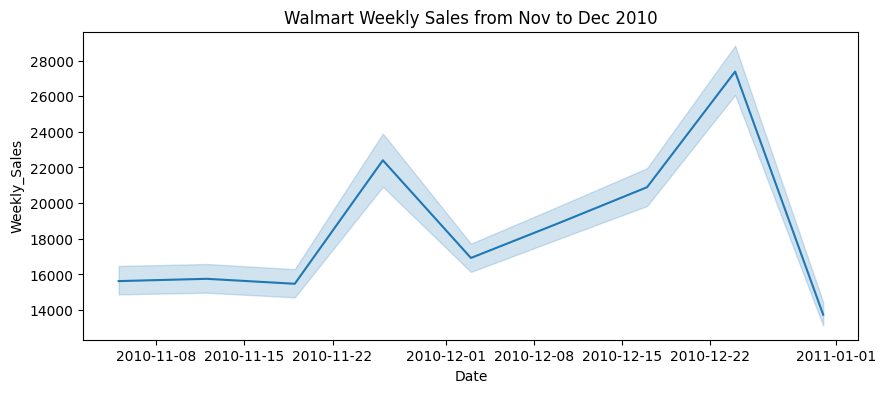

In [ ]:
plt.figure(figsize=(10,4))

# Plotting a line plot of 'Weekly_Sales' against 'Date' for the time range of peak
sns.lineplot(
    data=pdf.loc[(pdf.index >'2010-11-01') & (pdf.index<'2011-01-01')],
    x='Date', y='Weekly_Sales'
    ).set_title('Walmart Weekly Sales from Nov to Dec 2010')

plt.show()


**The spike is seen during ThanksGiving (23-Nov) Black Friday(24-Nov) and Christmas (25-Dec)**

### Analyzing Sales by Month, Quarter, Year

In [ ]:
# Extracting the day component from the index (Date) and storing it in a new column 'Day' in the pdf DataFrame
pdf['Day'] = pdf.index.day

# Extracting the month component from the index (Date) and storing it in a new column 'Month' in the pdf DataFrame
pdf['Month'] = pdf.index.month

# Extracting the quarter component from the index (Date) and storing it in a new column 'Quarter' in the pdf DataFrame
pdf['Quarter'] = pdf.index.quarter

# Extracting the year component from the index (Date) and storing it in a new column 'Year' in the pdf DataFrame
pdf['Year'] = pdf.index.year


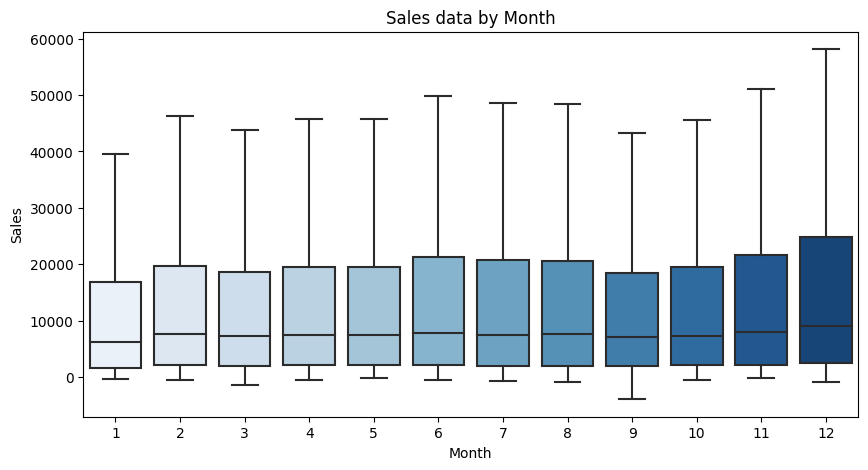

In [ ]:
plt.figure(figsize=(10,5))

# Plotting a box plot of 'Weekly_Sales' against 'Month' for the all months of the year 2011

# Excluding outliers from the visualization
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
            x='Month', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Month')

# Adding label to the y-axis
plt.ylabel('Sales')

plt.show()


- We can see the increase in sales in Nov(11) and December(12)  
- June(6) also has slightly higher sales  
- January(1) sales are lowest, it can be due to people avoiding shopping just after the holiday season  

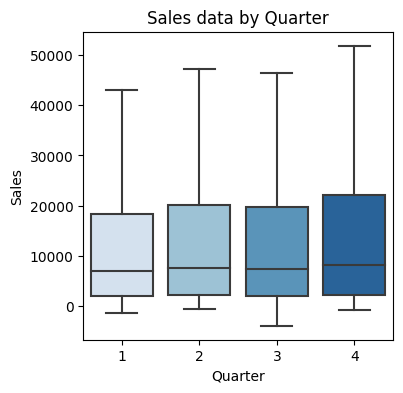

In [ ]:
# Creating a new figure with specified size for the box plot
plt.figure(figsize=(4,4))

# Plotting a box plot of 'Weekly_Sales' against 'Quarter' for the specified date range from the pdf DataFrame
# Excluding outliers from the visualization
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
            x='Quarter', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Quarter')

# Adding label to the y-axis
plt.ylabel('Sales')

# Displaying the plot
plt.show()


**Q4 has the highest sales(most probably due to holiady season in US)**

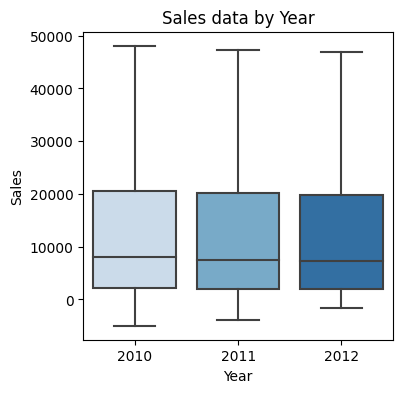

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Year', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year')
plt.ylabel('Sales')
plt.show()

**We see a decrease in Sales from 2010 to 2012, It can happen due to the following reasons:**  
- We dont have sales of Nov and Dec in 2012  
- We also dont have sales of Jan in 2010 (which might make the avg a little higher than 2011)  

#### Sales data by year

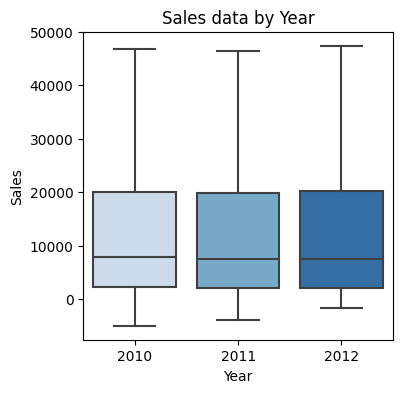

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year')
plt.ylabel('Sales')
plt.show()


**Taking data of Months Feb-Oct as they are available for all years**  
- We can see the sales is not decreasing over the years

#### Sales data by holiday

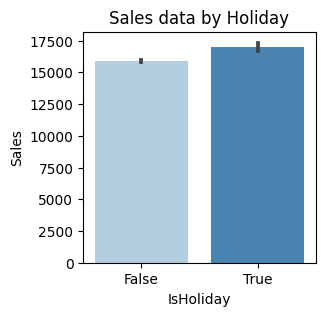

In [ ]:
# Creating a new figure with specified size for the bar plot
plt.figure(figsize=(3,3))

# Plotting a bar plot of 'Weekly_Sales' against 'IsHoliday' from the pdf DataFrame
sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales',
            palette='Blues'
           ).set_title('Sales data by Holiday')

plt.ylabel('Sales')

plt.show()


**Sales are slightly higher during Holidays**

### Analyzing Store Types with Sales

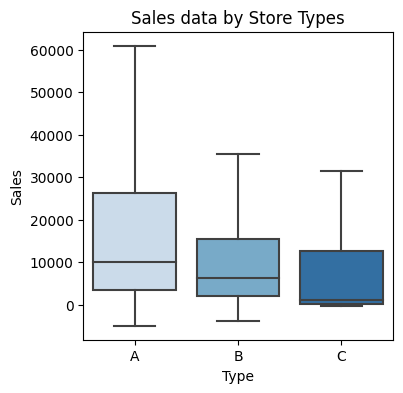

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Type', y='Weekly_Sales',
            palette='Blues' , showfliers=False
           ).set_title('Sales data by Store Types')
plt.ylabel('Sales')
plt.show()

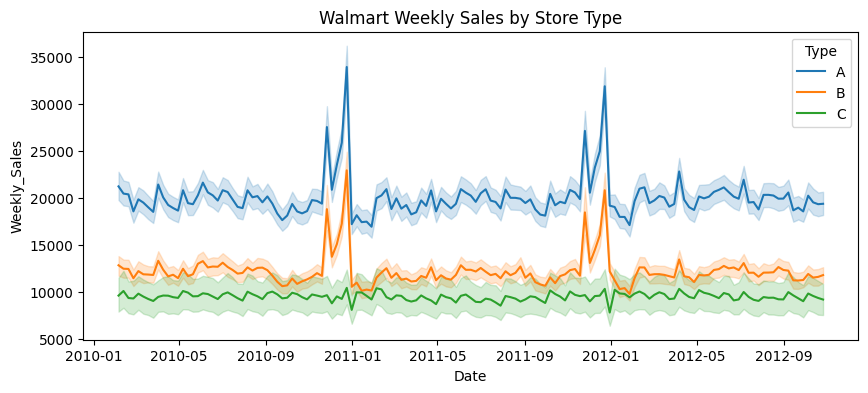

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Walmart Weekly Sales by Store Type')
plt.show()

**Bigger stores (A) have higher sales compared to smaller stores (B)**

### Analyzing additional Features with Sales

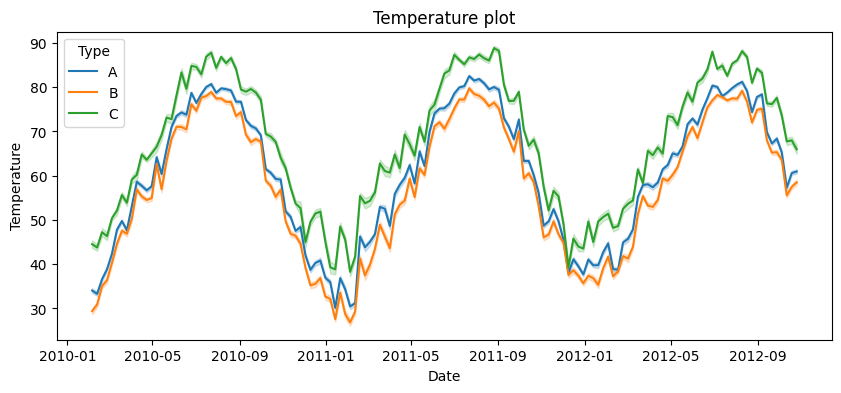

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Temperature',
             hue='Type',
             ax=ax,
            ).set_title('Temperature plot')
plt.show()

- Temperature around Type C stores (small stores) is high compared to other stores

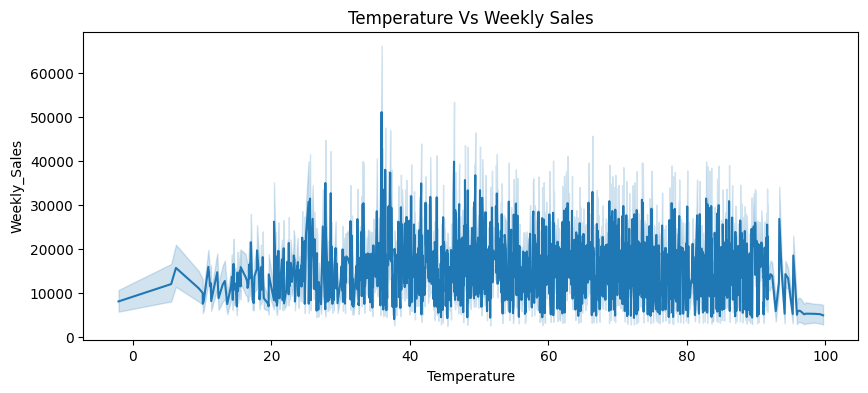

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
             x='Temperature',
             y='Weekly_Sales',
            ).set_title('Temperature Vs Weekly Sales')
plt.show()

**There is no effect of Temperature on Sales**

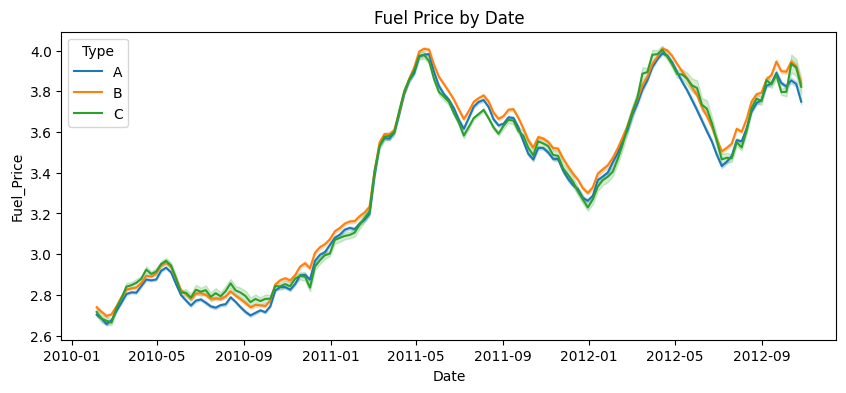

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Fuel_Price',
             hue='Type',
            ).set_title('Fuel Price by Date')
plt.show()

**Fuel price is identical for all store types**

In [ ]:
pdf['Fuel_Price_Change'] = pdf['Fuel_Price'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0)

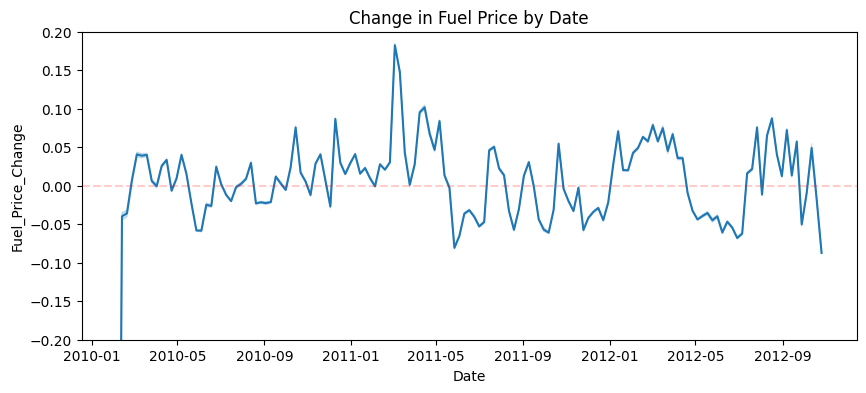

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Fuel_Price_Change',
             #hue='Type',
            ).set_title('Change in Fuel Price by Date')
plt.axhline(pdf['Fuel_Price_Change'].mean(), color='r', alpha=0.2, linestyle='--')
plt.ylim(-0.2, 0.2)
plt.show()

**The shift (Change) in fuel price moves around randomly with the mean of 0**

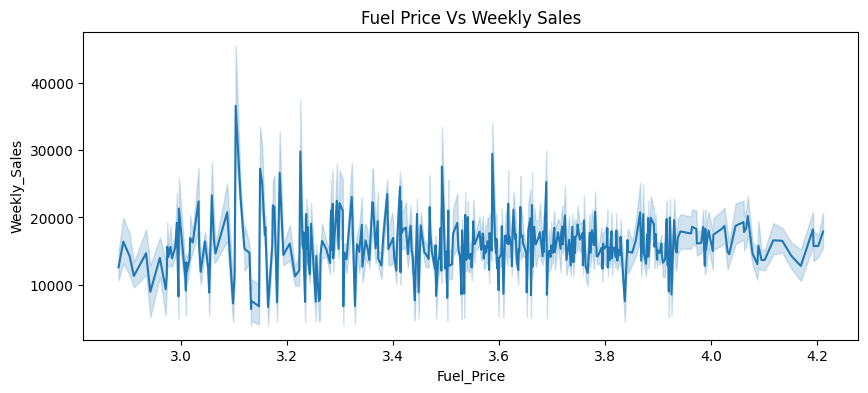

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
             x='Fuel_Price',
             y='Weekly_Sales',
            ).set_title('Fuel Price Vs Weekly Sales')
plt.show()

**There is no effect of Fuel Price of the region on Sales**

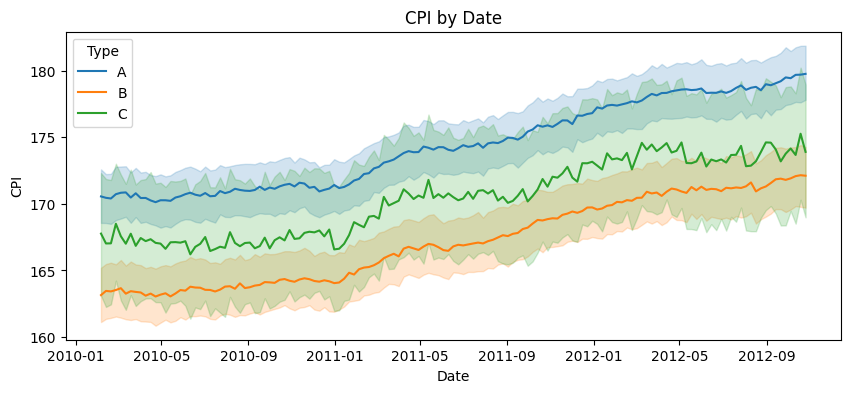

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='CPI',
             hue='Type'
            ).set_title('CPI by Date')
plt.show()

- Overall CPI (Consumer Price Index) is increase over time  
- Type A stores have highest CPI index  
- Type C stores have higher CPI index than Type B stores  

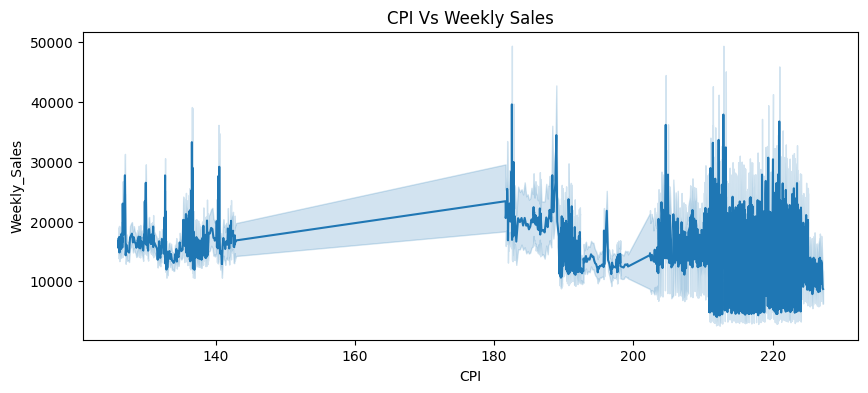

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='CPI',
             y='Weekly_Sales',
            ).set_title('CPI Vs Weekly Sales')
plt.show()

**There is no effect of CPI (Consumer Price Index) on sales**

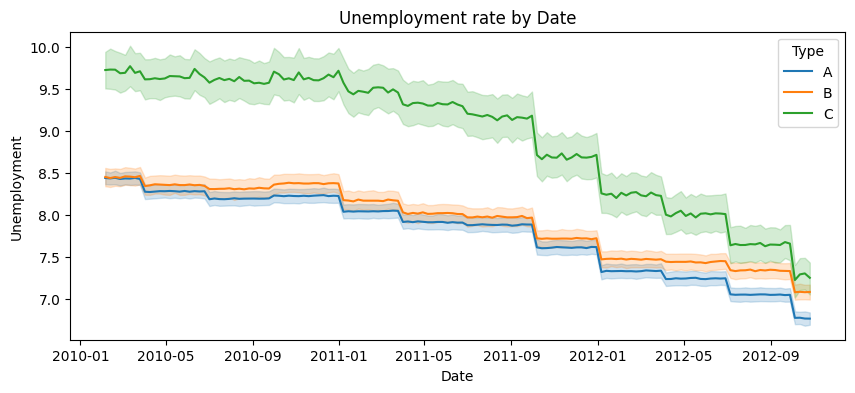

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Unemployment',
             hue='Type',
            ).set_title('Unemployment rate by Date')
plt.show()

- Unemployment Rate is descending over time
- Unemployment Rate is highest around Type C stores (small stores), they could be around rural areas
- Unemployment is similar around Type A and B stores

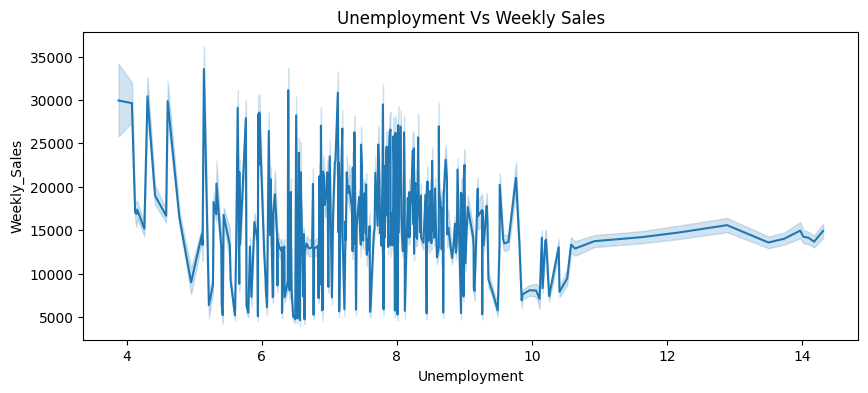

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Unemployment',
             y='Weekly_Sales',
            ).set_title('Unemployment Vs Weekly Sales')
plt.show()

**There is no effect of Unemployment on sales**

## Outlier Analysis

- There are several ways to treat outliers in a dataset, depending on the nature of the outliers and the problem being solved.  
- We will use **Capping** Technique to handle outliers.  
- First We will visualize the distribution of the data
- Then we will decide the values for capping

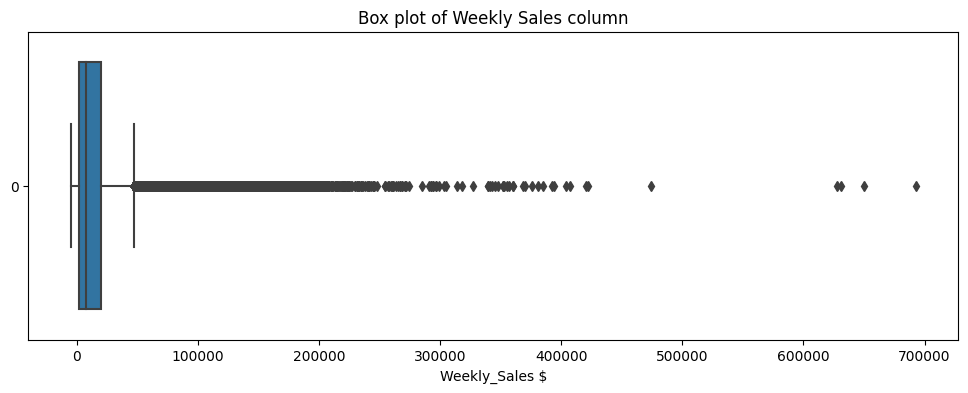

In [ ]:
plt.figure(figsize=(12,4))
sns.boxplot(pdf['Weekly_Sales'], orient='h')
plt.xlabel('Weekly_Sales $')
plt.title('Box plot of Weekly Sales column')
plt.show()

The data has large gaps after 200000

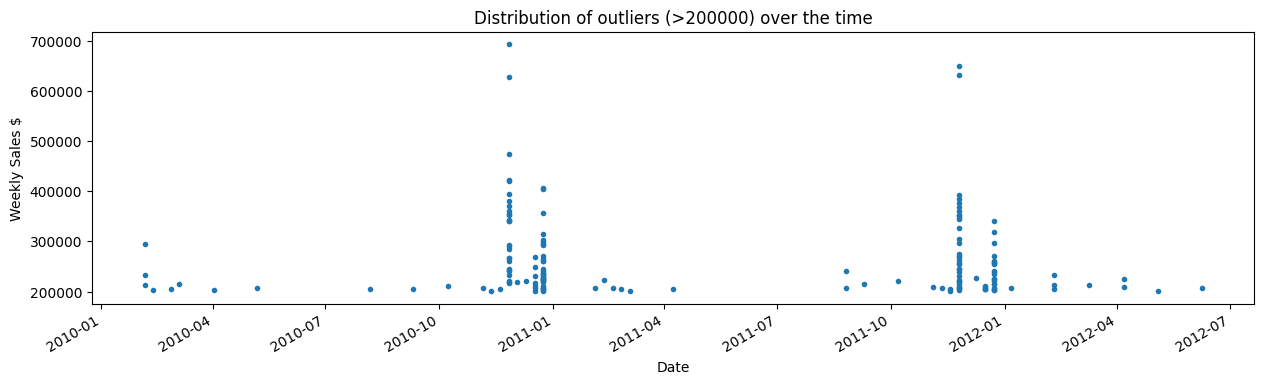

In [ ]:
pdf.query('Weekly_Sales > 200000')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of outliers (>200000) over the time')
plt.show()

Throughout the year, we have some positive outliers (sales more than 200000 $)
  
Now looking at Negative values

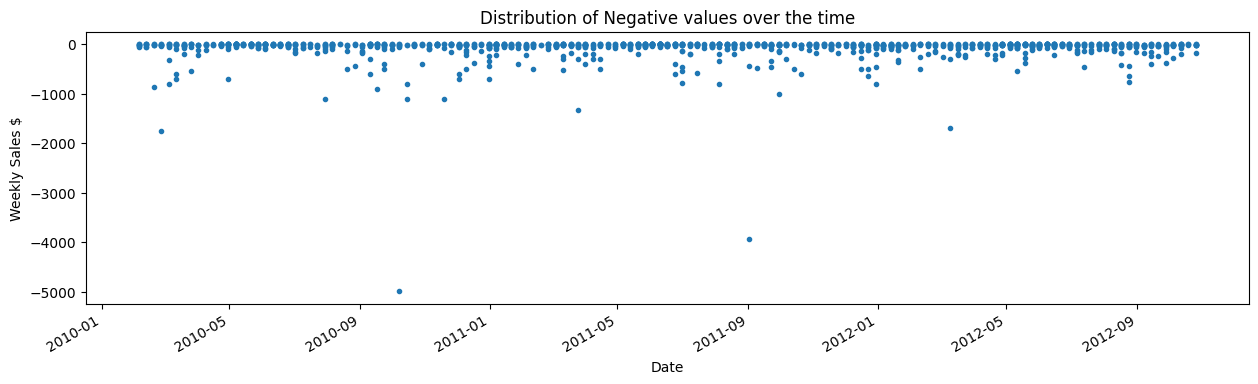

In [ ]:
pdf.query('Weekly_Sales < 0')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of Negative values over the time')
plt.show()

**We will remove these outliers before trainig the model**

In [ ]:
old_count = pdf.shape[0]
print('Dataset_size before removing outliers: ', old_count)
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
new_count = pdf.shape[0]
print('Dataset_size after removing outliers: ', pdf.shape[0])
print('Percent decrease in data: ', round((old_count - new_count)*100/old_count,2))

Dataset_size before removing outliers:  421570
Dataset_size after removing outliers:  420122
Percent decrease in data:  0.34


Only 0.34 % of the data was removed

## Correlation Matrix

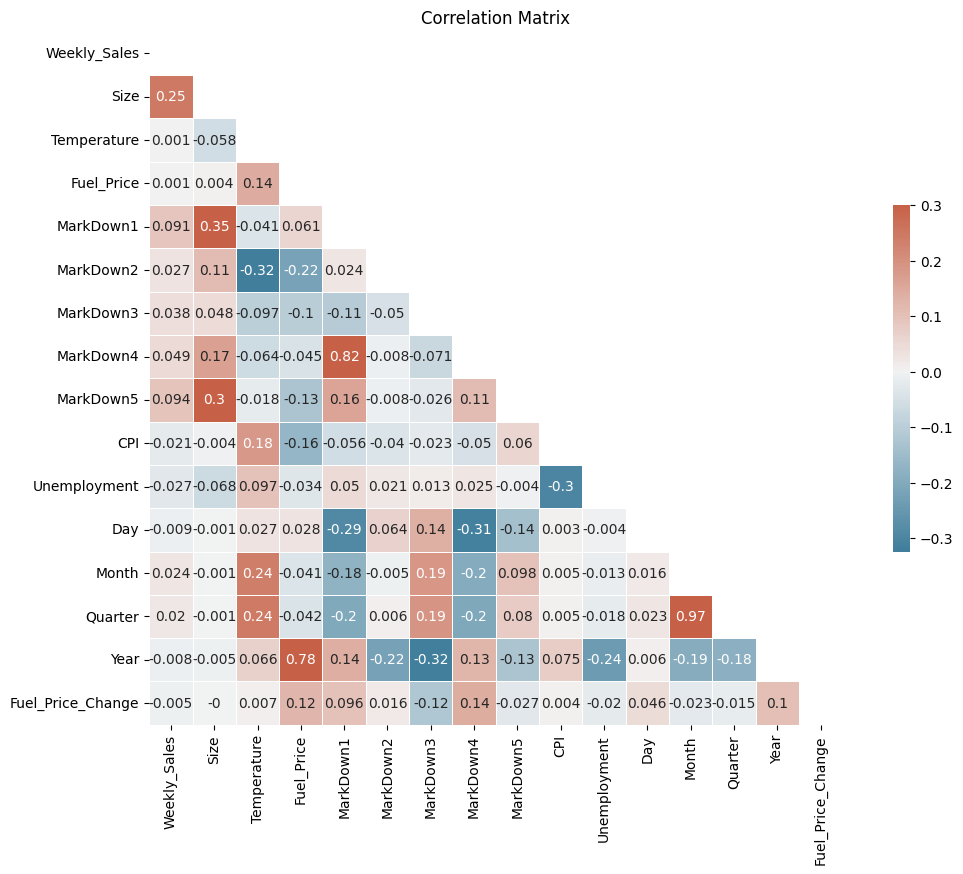

In [ ]:
# Numerical cols
num_cols = [x for x in pdf.columns if x not in ['Type','IsHoliday','Dept','Store']]

# Compute the correlation matrix
corr = pdf[num_cols].corr().round(3)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

- MarkDown4 and MarkDown1 have high correlation  
- MarkDown1 and MarkDown5 have positive correlation with Size  
    - They could be exclusive offers for bigger stores  
- MarkDown2 have negative correlation with Temperature  
    - MarkDown2 could be offers during winters / holiday offers  

## Pre Processing Data

In [ ]:
!pip install xgboost

## Joining Datasets and Creating features

In [ ]:
import pyspark.sql.functions as f


In [ ]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
# Converting 'NA' strings in MarkDown columns to null values
for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))
pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf['Day'] = pdf.index.day
pdf['Week'] = np.ceil(pdf.index.dayofyear/7).astype(int)
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
pdf.head().style.hide(axis="index")

Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Quarter,Year
1,1,24924.500000,False,A,151315,42.310000,2.572000,nan,nan,nan,nan,nan,211.096359,8.106000,5,6,2,1,2010
1,1,46039.490000,True,A,151315,38.510000,2.548000,nan,nan,nan,nan,nan,211.242172,8.106000,12,7,2,1,2010
1,1,41595.550000,False,A,151315,39.930000,2.514000,nan,nan,nan,nan,nan,211.289139,8.106000,19,8,2,1,2010
1,1,19403.540000,False,A,151315,46.630000,2.561000,nan,nan,nan,nan,nan,211.319641,8.106000,26,9,2,1,2010
1,1,21827.900000,False,A,151315,46.500000,2.625000,nan,nan,nan,nan,nan,211.350143,8.106000,5,10,3,1,2010


## Handling Missing values

In [ ]:
pdf.isnull().sum()

Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       269992
MarkDown2       309270
MarkDown3       283525
MarkDown4       285656
MarkDown5       269244
CPI                  0
Unemployment         0
Day                  0
Week                 0
Month                0
Quarter              0
Year                 0
dtype: int64

- **Only MarkDown columns have missing values.**  
- As they are anonimized offer related sales. We can assume if there is no data (NaN) for a particular day then the value is 0.  
- So we can replace nulls with 0.  

In [ ]:
pdf.fillna(0, inplace=True)

## Converting String / Boolean Columns into Numerical

Converting **"Is Holiday"** column to int  
Changing the type will replace True -> 1 and False -> 0  

In [ ]:
# Converting Is Holiday column to int
# Changing the type will replace True -> 1 and False -> 0
pdf['IsHoliday'] = pdf['IsHoliday'].astype('int')

Converting **Type of store** into numerical  
We will use the order of size to decide the numerical values for store types  
As we have seen Type **A stores are largest and C are smallest**,   
we will use the following mapping  
**C-> 0, B-> 1, A-> 2**

In [ ]:
# Converting Type of store into numerical
# We will use the order of size to decide the numerical values for store types
# As we have seen Type A stores are largest and C are smallest,
# we will use the following mapping
# C-> 0, B-> 1, A-> 2

pdf['Type'] = pdf['Type'].replace({'C': 0, 'B': 1, 'A': 2})

## XGBoost Model

In [ ]:
TARGET = ['Weekly_Sales']
FEATURES = [i for i in pdf.columns if i not in TARGET]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pdf[FEATURES], pdf[TARGET],
                                                   test_size=0.2, random_state=130)

In [ ]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                      learning_rate=0.5)
model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:15063.79170	validation_1-rmse:15139.93328
[100]	validation_0-rmse:4242.24583	validation_1-rmse:4492.70623
[200]	validation_0-rmse:3482.17459	validation_1-rmse:3878.64994
[300]	validation_0-rmse:3087.08542	validation_1-rmse:3587.85615
[400]	validation_0-rmse:2811.11912	validation_1-rmse:3408.92916
[500]	validation_0-rmse:2608.76790	validation_1-rmse:3287.69013
[600]	validation_0-rmse:2453.39392	validation_1-rmse:3205.62576
[700]	validation_0-rmse:2334.43202	validation_1-rmse:3135.30009
[800]	validation_0-rmse:2237.46742	validation_1-rmse:3089.50207
[900]	validation_0-rmse:2146.26464	validation_1-rmse:3049.58338
[1000]	validation_0-rmse:2069.41808	validation_1-rmse:3019.87896
[1100]	validation_0-rmse:2000.64612	validation_1-rmse:2989.92329
[1200]	validation_0-rmse:1937.12835	validation_1-rmse:2962.81252
[1300]	validation_0-rmse:1882.34812	validation_1-rmse:2942.05732
[1400]	validation_0-rmse:1837.24162	validation_1-rmse:2926.77431
[1500]	validation_0-rmse:1783.89858

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
xgboost_accuracy = reg.score(X_test,y_test)*100
print("XGB Regressor Evaluation Metrics: ")
print("Accuracy", round(xgboost_accuracy,3))
print("MAE \t" , round(metrics.mean_absolute_error(y_test, y_pred),3))
print("MSE \t" , round(metrics.mean_squared_error(y_test, y_pred),3))
print("RMSE \t" , round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print("R2 \t" , round(metrics.explained_variance_score(y_test, y_pred),5))

XGB Regressor Evaluation Metrics: 
Accuracy 98.348
MAE 	 1570.744
MSE 	 8134464.931
RMSE 	 2852.098
R2 	 0.98348


In [ ]:
print('Top 10 features with their Feature importance scores: ')
pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Feature Importance']).sort_values('Feature Importance', ascending=False).head(10)

Top 10 features with their Feature importance scores: 


,Feature Importance
Size,0.349576
Dept,0.214630
Type,0.146933
Store,0.098718
CPI,0.038189
Week,0.030618
IsHoliday,0.024891
Month,0.023361
Year,0.019829
Unemployment,0.011220


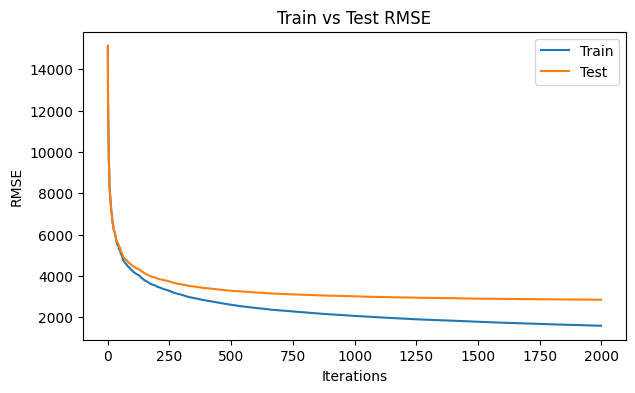

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
score_hist = pd.DataFrame({'Train_rmse':model.evals_result()['validation_0']['rmse'], 'Test_rmse':model.evals_result()['validation_1']['rmse']})
sns.lineplot(score_hist['Train_rmse'], ax=ax, label='Train')
sns.lineplot(score_hist['Test_rmse'], ax=ax, label='Test')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('Train vs Test RMSE')
plt.show()

In [ ]:
val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]
val['prediction'] = reg.predict(X_val)

/tmp/ipykernel_48/2158810898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [ ]:
val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]
val['prediction'] = reg.predict(X_val)

fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['prediction'], ax=ax, label='Prediction')
plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Actual Vs predictions')
plt.show()

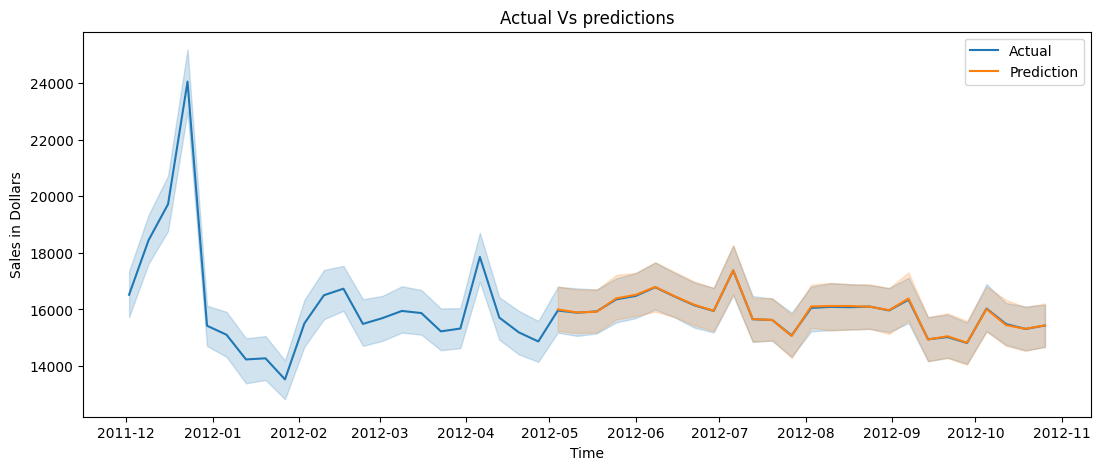

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['prediction'], ax=ax, label='Prediction')
plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Actual Vs predictions')
plt.show()

The Predictions are pretty close to the actual values as we have a **accuracy of 98%**

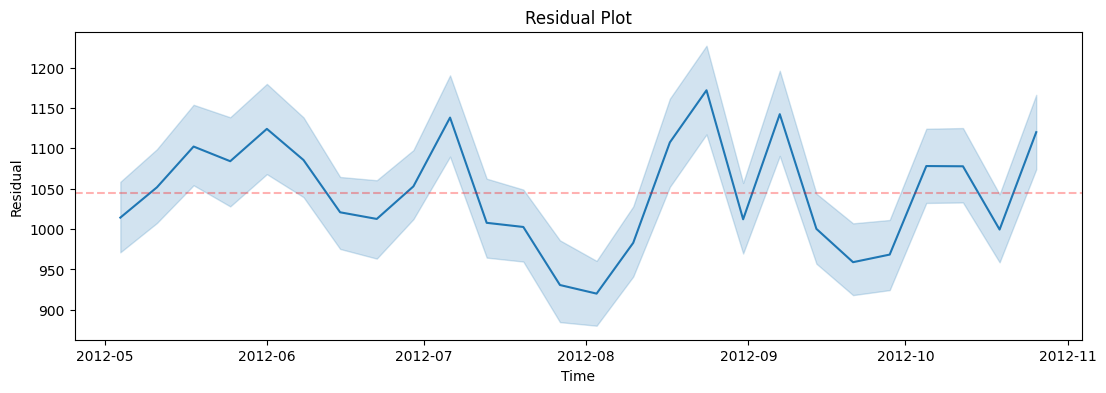

In [ ]:
val = val.assign(Residual= abs(val['Weekly_Sales'] - val['prediction']))
fig, ax = plt.subplots(1,1,figsize=(13,4))
#sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['Residual'], ax=ax)
plt.axhline(val['Residual'].mean(), linestyle='--', color='r', alpha=0.3)
#plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Residual Plot')
plt.show()

The residuals are close to the MAE

# **Other regression models**

Model: Linear Regression
Mean Squared Error (MSE) on Validation Set: 440099339.88
Mean Absolute Error (MAE) on Validation Set: 14552.97
R-squared (R2) on Validation Set: 0.09
-----------------------------------


/tmp/ipykernel_47/3162355335.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


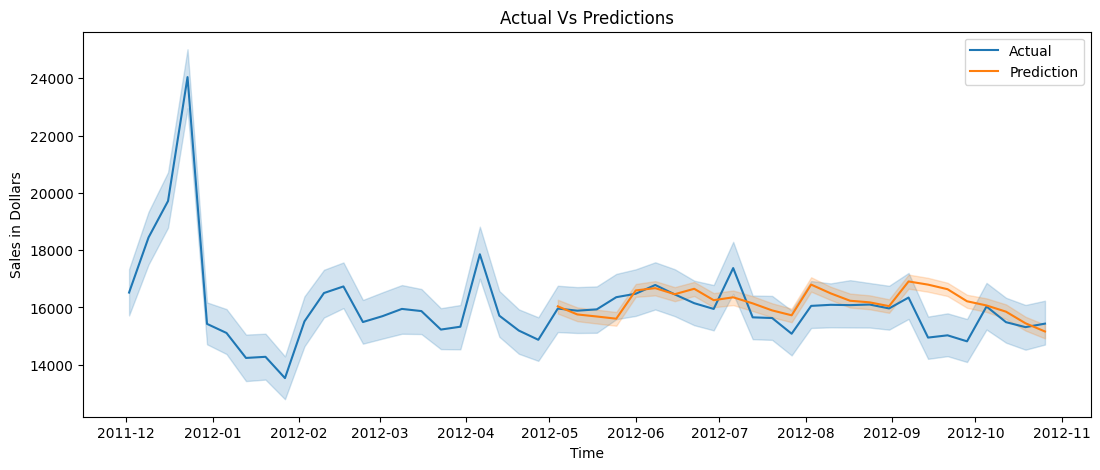

Model: Ridge Regression
Mean Squared Error (MSE) on Validation Set: 440099322.12
Mean Absolute Error (MAE) on Validation Set: 14552.97
R-squared (R2) on Validation Set: 0.09
-----------------------------------


/tmp/ipykernel_47/3162355335.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


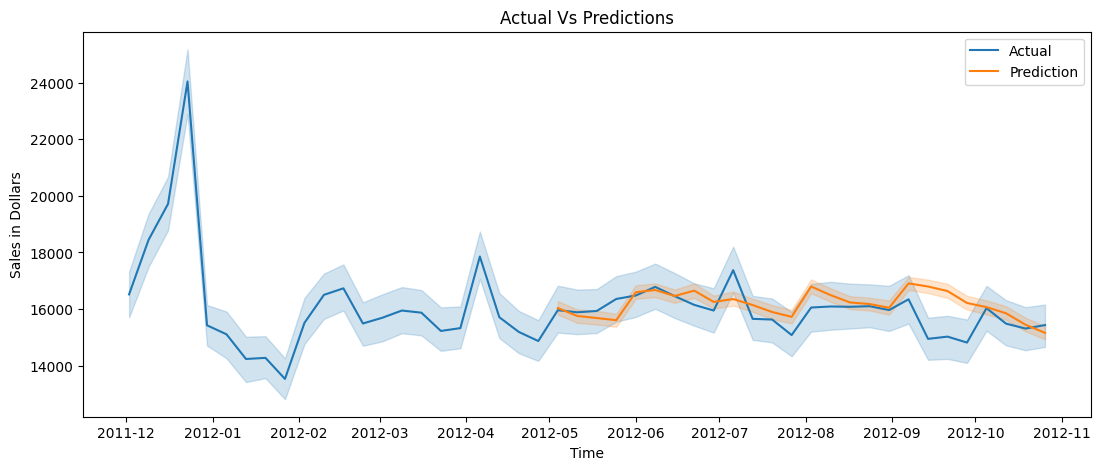

Model: Lasso Regression
Mean Squared Error (MSE) on Validation Set: 440090349.07
Mean Absolute Error (MAE) on Validation Set: 14551.60
R-squared (R2) on Validation Set: 0.09
-----------------------------------


/tmp/ipykernel_47/3162355335.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


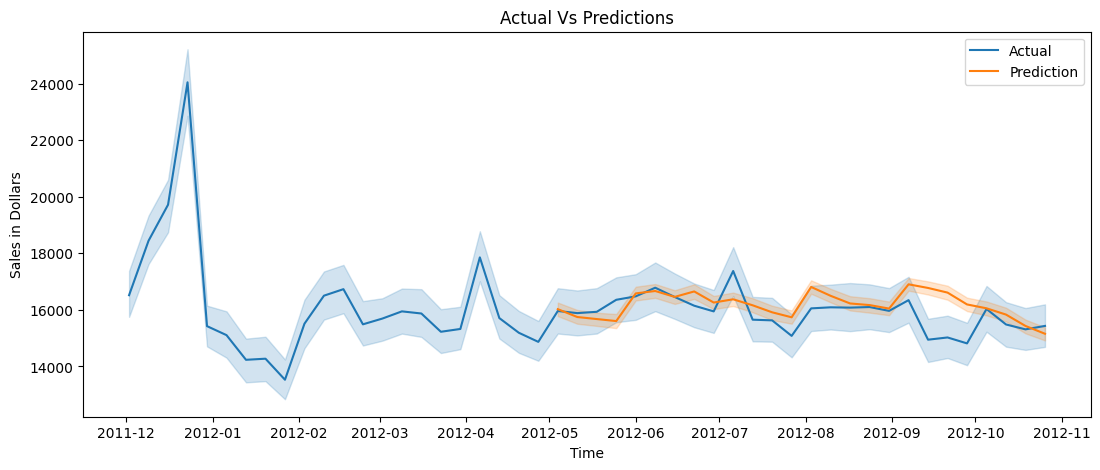

/tmp/ipykernel_47/3162355335.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Model: Random Forest Regression
Mean Squared Error (MSE) on Validation Set: 1792913.23
Mean Absolute Error (MAE) on Validation Set: 570.63
R-squared (R2) on Validation Set: 1.00
-----------------------------------


/tmp/ipykernel_47/3162355335.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


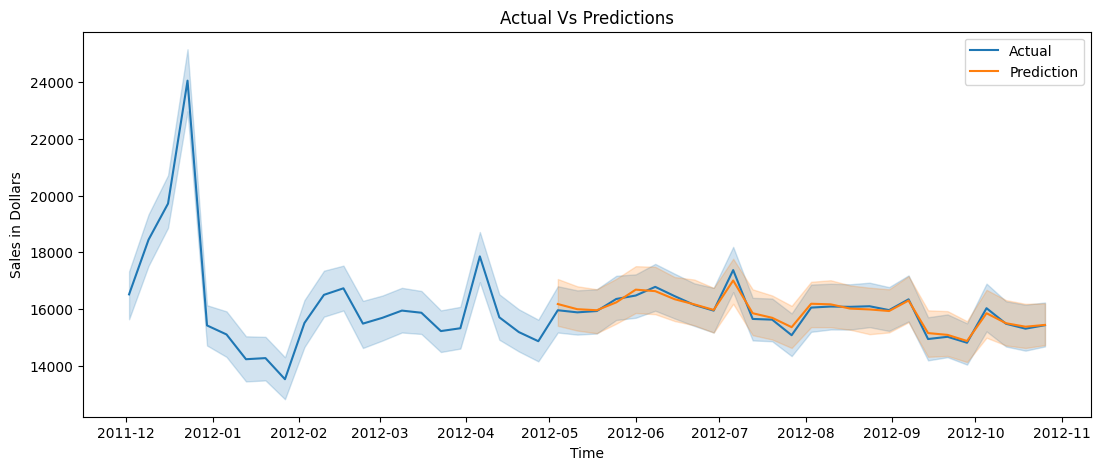

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import matplotlib.pyplot as plt
import seaborn as sns

val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]

# Define a function to plot actual vs predicted sales
def plot_actual_vs_predicted(reg, X_val, y_val):
    val['prediction'] = reg.predict(X_val)

    fig, ax = plt.subplots(1,1,figsize=(13,5))
    sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
    sns.lineplot(val['prediction'], ax=ax, label='Prediction')
    plt.ylabel('Sales in Dollars')
    plt.xlabel('Time')
    plt.title('Actual Vs Predictions')
    plt.legend()
    plt.show()


models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge()),
    ("Lasso Regression", Lasso()),
    ("Random Forest Regression", RandomForestRegressor())
]

# Iterate over each model
for name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    predictions_val = model.predict(X_val)

    # Calculate regression metrics
    mse_val = mean_squared_error(y_val, predictions_val)
    mae_val = mean_absolute_error(y_val, predictions_val)
    r2_val = r2_score(y_val, predictions_val)

    # Print the regression metrics for each model
    print(f"Model: {name}")
    print(f"Mean Squared Error (MSE) on Validation Set: {mse_val:.2f}")
    print(f"Mean Absolute Error (MAE) on Validation Set: {mae_val:.2f}")
    print(f"R-squared (R2) on Validation Set: {r2_val:.2f}")
    print("-----------------------------------")

    # Plot actual vs predicted sales for each model
    plot_actual_vs_predicted(model, X_val, y_val)



## Predicting Overall sales per day using SARIMA Model

#### Preparing Dataset (cumulating sales for all stores)

In [ ]:
cum_pdf = pdf['Weekly_Sales'].groupby('Date').sum().to_frame(name='Weekly_Sales')

In [ ]:
train = cum_pdf.loc[cum_pdf.index < '2012-05-01']
test = cum_pdf.loc[cum_pdf.index >= '2012-05-01']

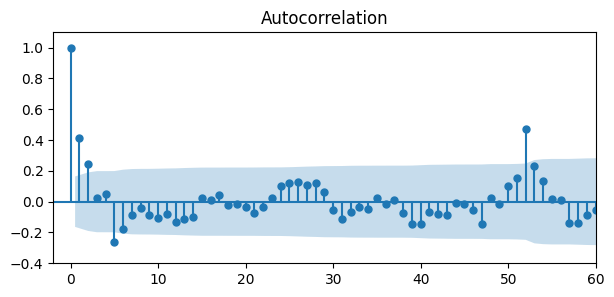

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(7,3))
acf_plot = plot_acf(cum_pdf.Weekly_Sales, lags=100, ax=ax)
plt.ylim(-0.4, 1.1)
plt.xlim(-2,60)
plt.show()

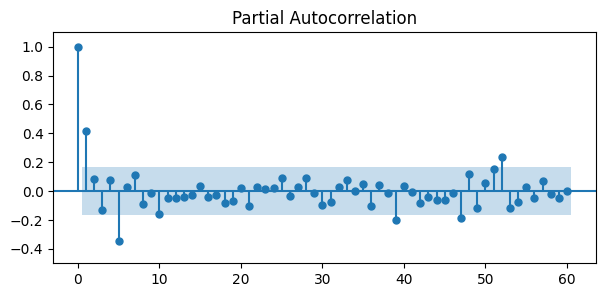

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))
pacf_plot = plot_pacf(cum_pdf.Weekly_Sales, lags=60, ax=ax)
plt.ylim(-0.5, 1.1)
plt.show()

**Based on PACF, we should start with Auto Regressive(AR) model with lags 1,2,5,52**

### AD-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(cum_pdf.Weekly_Sales)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.357042012534242
p-value: 2.5278147982296737e-08


As the p-value is less than 0.05 and ADF statistic is a negative number  
**The Time series is Stationary**

In [ ]:
import statsmodels.api as sm
order_aic_bic =[]

# Loop over p values from 0-2
for p in [1,2,5,52]:
    # Loop over q values from 0-2
    for q in [1,2,5,52]:

        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(p, 0, q))
            results = model.fit(maxiter=100, full_output=False, disp=False)

            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)

# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  

In [ ]:
# lets sort them by AIC and BIC

# Sort by AIC
print("Sorting SARIMA model with different (p,q) by AIC ")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Sort by BIC
print("Sorted by BIC ")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))

Sorting SARIMA model with different (p,q) by AIC 


     p   q          aic          bic
0   52   5  3879.143850  4039.349938
1   52   2  3882.504447  4034.424014
2   52   1  3882.620320  4031.777712
3    1   5  3920.531866  3939.867083
4    5   5  3925.503671  3955.887584
5    2   1  3930.915414  3941.964109
6    1   2  3937.795438  3948.844134
7    5   2  3939.889030  3961.986422
8    5   1  3942.014748  3961.349966
9    1   1  3942.865561  3951.152083
10   2   2  3945.281683  3959.092553
11   2   5  3973.679744  3995.777135
12   1  52  3981.262006  4130.419398
13   2  52  3982.787185  4134.706752
14   5  52  4001.086178  4161.292266
15  52  52  4060.930503  4350.958766
Sorted by BIC 


     p   q          aic          bic
0    1   5  3920.531866  3939.867083
1    2   1  3930.915414  3941.964109
2    1   2  3937.795438  3948.844134
3    1   1  3942.865561  3951.152083
4    5   5  3925.503671  3955.887584
5    2   2  3945.281683  3959.092553
6    5   1  3942.014748  3961.349966
7    5

p = 1 and q = 5 gives the lowest BIC &  
p = 52 and q = 5 gives the lowest AIC

In [ ]:
# The model with the best p and q found from pervious step
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(52, 0, 5))
# Fit model
results = model.fit()
# Assign residuals to variable
residuals = results.resid

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           58     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72251D+02    |proj g|=  8.98967D+02


 This problem is unconstrained.



At iterate    5    f=  2.19392D+01    |proj g|=  4.95783D+00

At iterate   10    f=  1.67367D+01    |proj g|=  1.15255D+00

At iterate   15    f=  1.62973D+01    |proj g|=  3.05482D-01

At iterate   20    f=  1.62719D+01    |proj g|=  8.10839D-02

At iterate   25    f=  1.62507D+01    |proj g|=  1.37822D-01

At iterate   30    f=  1.62038D+01    |proj g|=  3.15196D-01

At iterate   35    f=  1.61688D+01    |proj g|=  6.95436D-02

At iterate   40    f=  1.61619D+01    |proj g|=  6.27600D-02

At iterate   45    f=  1.61509D+01    |proj g|=  6.75400D-02

At iterate   50    f=  1.61388D+01    |proj g|=  1.28164D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  117
Model:              SARIMAX(52, 0, 5)   Log Likelihood               -1888.234
Date:                Tue, 07 May 2024   AIC                           3892.468
Time:                        13:39:48   BIC                           4052.675
Sample:                    02-05-2010   HQIC                          3957.510
                         - 04-27-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0094      0.114      0.082      0.934      -0.214       0.233
ar.L2          0.0342      0.104      0.328      0.743      -0.170       0.239
ar.L3         -0.0228      0.103     -0.222      0.824      -0.224       0.178
ar.L4         -0.0243      0.112     -0.216      0.829      -0.244       0.196
ar.L5         -0.0189      0.067     -0.282      0.778      -0.151       0.113
ar.L6         -0.0916      0.078     -1.167      0.243      -0.245       0.062
ar.L7          0.0897      0.079      1.133      0.257      -0.065       0.245
ar.L8         -0.0355      0.096     -0.372      0.710      -0.223       0.152
ar.L9         -0.0663      0.089     -0.745      0.456      -0.241       0.108
ar.L10         0.0420      0.080      0.526      0.599      -0.115       0.199
ar.L11        -0.0529      0.073     -0.730      0.466      -0.195       0.089
ar.L12         0.0868      0.089      0.981      0.327      -0.087       0.260
ar.L13        -0.0087      0.075     -0.116      0.907      -0.156       0.139
ar.L14        -0.1021      0.088     -1.161      0.246      -0.274       0.070
ar.L15         0.1065      0.072      1.477      0.140      -0.035       0.248
ar.L16         0.0329      0.074      0.443      0.658      -0.113       0.179
ar.L17         0.0278      0.076      0.368      0.713      -0.120       0.176
ar.L18         0.0066      0.058      0.113      0.910      -0.107       0.120
ar.L19        -0.0276      0.083     -0.332      0.740      -0.191       0.136
ar.L20         0.0449      0.089      0.507      0.612      -0.129       0.218
ar.L21        -0.0335      0.101     -0.332      0.740      -0.231       0.164
ar.L22        -0.0095      0.098     -0.097      0.923      -0.202       0.183
ar.L23         0.0226      0.100      0.225      0.822      -0.174       0.219
ar.L24         0.0116      0.126      0.092      0.927      -0.235       0.258
ar.L25         0.0769      0.118      0.653      0.514      -0.154       0.308
ar.L26        -0.0114      0.086     -0.133      0.894      -0.180       0.157
ar.L27        -0.0137      0.120     -0.114      0.909      -0.249       0.222
ar.L28         0.0692      0.100      0.693      0.488      -0.127       0.265
ar.L29         0.0137      0.110      0.125      0.901      -0.202       0.229
ar.L30         0.0151      0.101      0.151      0.880      -0.182       0.212
ar.L31        -0.0114      0.079     -0.144      0.886      -0.167       0.144
ar.L32         0.0137      0.104      0.132      0.895      -0.189       0.217
ar.L33         0.0860      0.099      0.867      0.386      -0.108       0.280
ar.L34        -0.0366      0.089     -0.411      0.681      -0.211       0.138
ar.L35        -0.0086      0.097     -0.089      0.929      -0.198       0.181
ar.L36        -0.0006      0.093     -0.007      0.994      -0.182       0.181
ar.L37        -0.0382      0.085     -0.452      0.652      -0.204       0.128
ar.L38         0.1336      0.107      1.249      0.212      -0.076       0.343
ar

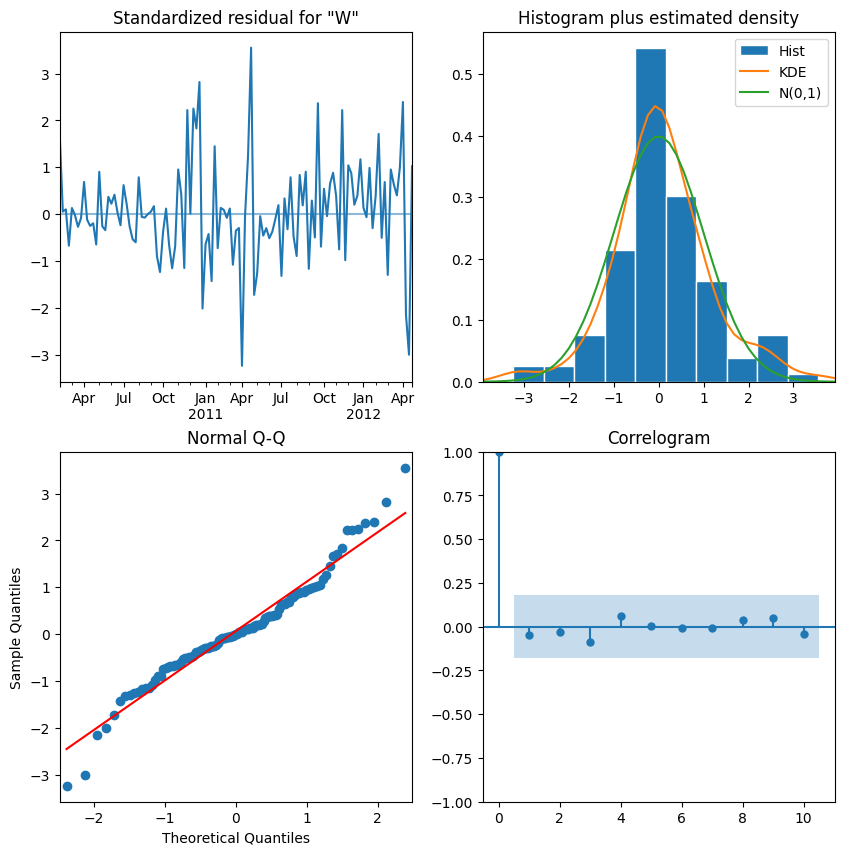

In [ ]:
results.plot_diagnostics(figsize=(10,10))
plt.show()

**Standardized residuals plot:** The top left plot shows one-step-ahead standardized residuals. If our model is working correctly, there should be no obvious pattern in the residuals. This is shown here in this case.  
**Histogram plus estimated density plot:** This plot shows the distribution of the residuals. The histogram shows us the measured distribution; the orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same. Here there are little differences between them, which indicate that our model is doing great.  
**Normal Q-Q plot:** The Q-Q plot compare the distribution of the residuals to the normal distribution. If the distribution of the residuals is normal, then all the points should lie along the red line, except for some values at the end.  
**Correlogram plot:** The correlogram plot is the ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant (within the blue shades). If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model.

### Predictions

In [ ]:
#get the predictions and residuals
predictions = results.forecast(len(test))
predictions = pd.Series(predictions, index=test.index).to_frame(name='Weekly_Sales')
residuals = test - predictions

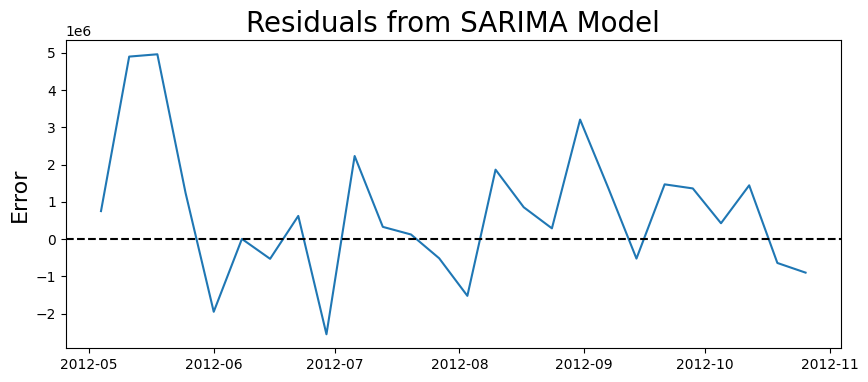

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title( 'Residuals from SARIMA Model' ,fontsize=20)
plt.ylabel( 'Error', fontsize=16)
plt.show()

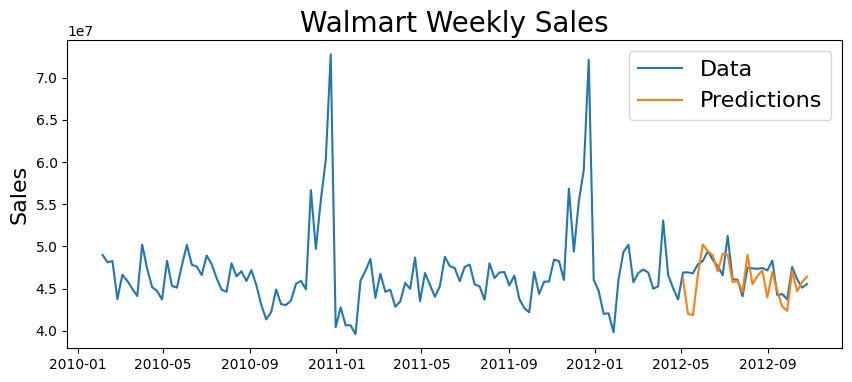

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cum_pdf)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Walmart Weekly Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

In [ ]:
print('MAPE: ', round(np.mean(abs(residuals/test)),4))
# The mean absolute error
mae = np.mean(np.abs(residuals))
print("Mean Absolute Error: ", mae)
print('Root Mean Squared Error: ', round(np.sqrt(np.mean(residuals**2)),2))

MAPE:  0.0299
Mean Absolute Error:  1406495.757228183
Root Mean Squared Error:  1896605.36


In comparison to SARIMA model, the **XGBoost model performs much better** as it uses multidimentional data  